In [1]:
%matplotlib inline

import tkinter
import matplotlib
import platform
if platform.system() not in ['Linux', 'Darwin'] and not platform.system().startswith('CYGWIN'):
    matplotlib.use('TKAgg')
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
plt.rcParams.update({'font.size': 8})

# 活化函數大清點 (pytorch)

In [2]:
import gc
import glob
import os
import cv2
from  collections import OrderedDict
os.environ['TRIDENT_BACKEND'] = 'pytorch'
import trident as T
from trident import *
from trident.layers.pytorch_activations import __all__

Using Pytorch backend.
Image Data Format: channels_first.
Image Channel Order: bgr.
Pytorch version:1.3.1.
Pillow version:6.2.1.
Using pillow image backend.


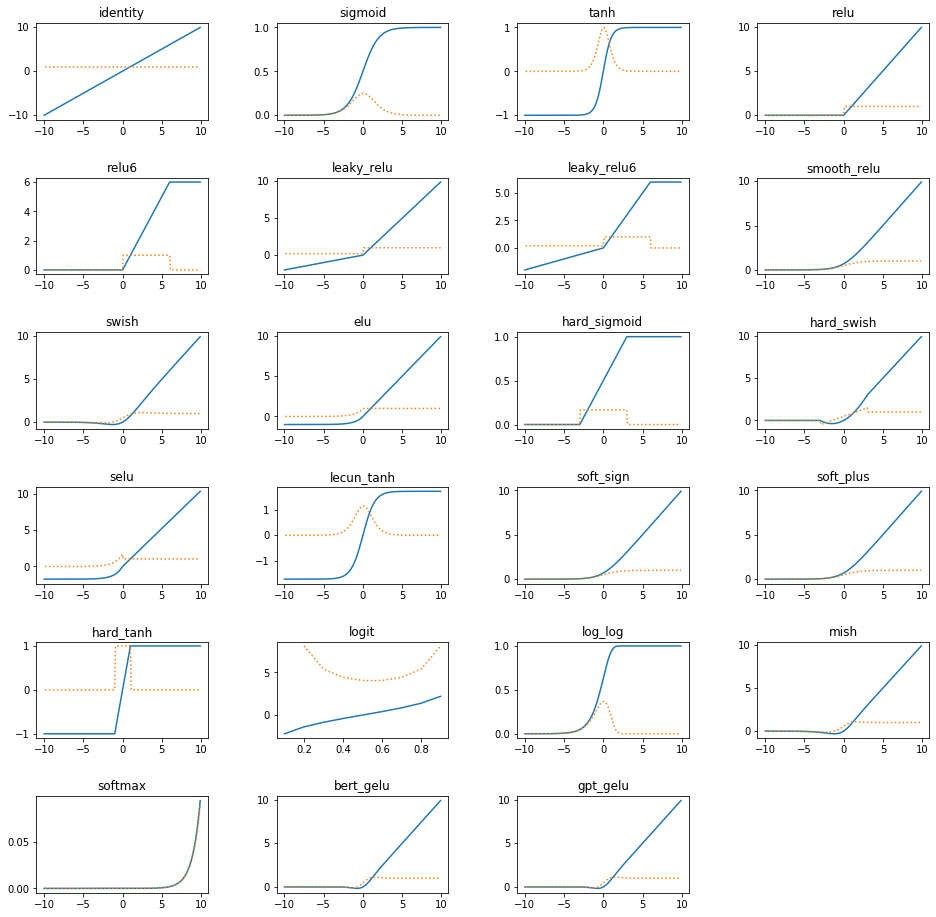

In [3]:
fig=plt.figure(figsize=(16,16))
plt.subplots_adjust(wspace=0.4, hspace=0.6)
n=1
items= __all__[int( len(__all__)//2):-1]
plt.clf()
for k in  items :
    if k not in ('p_relu','prelu'):
        try:
            act_fn=get_activation(k)
            x =np.arange(-10, 10, 0.1).astype(np.float32)
            tensor_x=to_tensor(x)
            y=to_numpy(act_fn(tensor_x))
            ax1 = fig.add_subplot(6, 4, n)
            ax1.plot(x,y)
            ax1.plot(x[1:], np.diff(y) /(np.diff(x)+1e-8),ls=':')
            ax1.set_title(k)
            
        except Exception as e:
            print(e)
            pass
        n+=1
display.display(fig)

In [4]:
dataset=T.load_mnist('mnist','train',is_flatten=True)
dataset.image_transform_funcs=[normalize(127.5,127.5)]       


archive file is already existing, donnot need download again.
archive file is already existing, donnot need download again.
Mapping data  in train scenario  success, total 60000 record addeds.
Mapping label  in train scenario  success, total 60000 records added.
Mapping class_names  in en-US   success, total 10 class names added.


archive file is already existing, donnot need download again.
archive file is already existing, donnot need download again.
Mapping data  in train scenario  success, total 60000 record addeds.
Mapping label  in train scenario  success, total 60000 records added.
Mapping class_names  in en-US   success, total 10 class names added.
(64, 784)


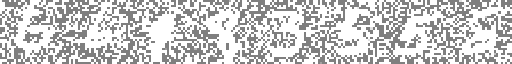

In [5]:
noise_dataset=T.load_mnist('mnist','train',is_flatten=True)
noise_dataset.image_transform_funcs=[normalize(127.5,127.5),add_noise(intensity=0.3)]       
noise_dataset.minibatch_size=64

im,label=noise_dataset.__next__()
print(im.shape)
im=array2image(np.concatenate(np.reshape(im[:8,:]*127.5+127.5,(8,28,28)).tolist(),1)).resize((64*8,64))
im

In [6]:
activations=['relu','sigmoid','tanh','selu','swish','mish']
performance_dict=OrderedDict()
def test_activity_function(act):
    performance_dict[act]=OrderedDict()
    #清掉記憶體垃圾以避免影響效能
    gc.collect()
    act_func=get_activation(act)
    print(act)
    
    #計算跑 10 萬次的總時間
    data =to_tensor(np.random.standard_normal((100000,1))) 
    start = time.time()
    results=[act_func(data[i]) for  i  in range(100000)]
    sec = time.time() - start
    print('{0:.6f} sec'.format(sec))
    performance_dict[act]['跑 10 萬次的總時間']=sec

    #建 mnist模
    net=Sequential(
    Dense(64,use_bias=False,activation=act),
    Dense(10,use_bias=False,activation='softmax'))
   

    #為了避免 Adam自適應調整對測試的影響，這裡使用SGD 
    model=Model(input_shape=[28*28],output=net)\
    .with_optimizer(optimizer='SGD',lr=1e-3)\
    .with_loss(CrossEntropyLoss)\
    .with_metric(accuracy)
    
    plan=TrainingPlan()\
    .add_training_item(model)\
    .with_data_loader(dataset)\
    .within_minibatch_size(128)\
    .print_progress_scheduling(100,unit='batch')\

    #讓他跑1000 次，過程中的權重變化與梯度變化都保留
    plan.only_steps(num_steps=1000,keep_weights_history=True,keep_gradient_history=True )
   
    #計算效度指標
    print('最低 loss {0:.4e}  最佳 metrics {1:.4%}  最後10次 metrics {2:.4%}'.format(min(plan.training_items[0].batch_loss_history['total_losses']),\
                                                                              max(plan.training_items[0].batch_metric_history['accuracy']) ,\
                                                                              np.array(plan.training_items[0].batch_metric_history['accuracy'][-10:]).mean()))
    performance_dict[act]['最佳 metrics']= max(plan.training_items[0].batch_metric_history['accuracy'])
    performance_dict[act]['最後10次 metrics']= np.array(plan.training_items[0].batch_metric_history['accuracy'][-10:]).mean()
    # 分別使用乾淨數據與噪聲數據進行推論
    net.eval()
    accuracys=[]
    for i in range(100):
        input,target=dataset.__next__()
        input,target=to_tensor(input),to_tensor(target)
        accuracys.append(to_numpy(accuracy(net(input),target)))
    accuracys=np.asarray(accuracys)
        
    print('正常樣本 accuracy {0:.4%}  DIFF: {1:.4%} '.format(accuracys.mean(),accuracys.mean()-np.array(plan.training_items[0].batch_metric_history['accuracy'][-10:]).mean()))
    performance_dict[act]['正常樣本 accuracy DIFF']=accuracys.mean()-np.array(plan.training_items[0].batch_metric_history['accuracy'][-10:]).mean()
    
    
    noise_accuracys=[]
    for i in range(100):
        input,target=noise_dataset.__next__()
        input,target=to_tensor(input),to_tensor(target)
        noise_accuracys.append(to_numpy(accuracy(net(input),target)))
    noise_accuracys=np.asarray(noise_accuracys)
        
    print('噪聲樣本 accuracy {0:.4%}  DIFF: {1:.4%} '.format(noise_accuracys.mean(),noise_accuracys.mean()-np.array(plan.training_items[0].batch_metric_history['accuracy'][-10:]).mean()))
    performance_dict[act]['噪聲樣本 accuracy DIFF']=noise_accuracys.mean()-np.array(plan.training_items[0].batch_metric_history['accuracy'][-10:]).mean()
    
    #繪製梯度與權重分布
    weights_history=plan.training_items[0].weights_history
    gradients_history=plan.training_items[0].gradients_history
   
    grads=[]
    weights=[]
    for i in range(len(gradients_history)):
        grads.append(gradients_history[i]['0.weight'].reshape([-1]))

    for i in range(len(weights_history)):
         weights.append(weights_history[i]['0.weight'].reshape([-1]))
 
    grads=np.asarray(grads)
    weights=np.asarray(weights)
    #計算梯度為零比例
    print('梯度為零比例 : {0:.3%}'.format(np.equal(grads,0).astype(np.float32).mean()))
    performance_dict[act]['梯度為零比例']=np.equal(grads,0).astype(np.float32).mean()
    performance_dict[act]['負梯度比例']=np.less(grads,0).astype(np.float32).mean()
    
    steps_histogram(grads,weights,inteval=50,imshow=True)
    
    
    fig = plt.figure(figsize=(18,8))
    for i in [1,2]:
        ax= fig.add_subplot(1, 2, i, projection = '3d')


        # Make data.
        X = np.arange(0, 28, 1)
        Y = np.arange(0, 28, 1)
        X, Y = np.meshgrid(X, Y)
        grad_grid=gradients_history[0 if i==1 else-1]['0.weight'][0,:].reshape([28,28])
        Z = grad_grid[Y,X]

        surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

        # Customize the z axis.
        ax.set_zlim(grad_grid.min()*1.1,grad_grid.max()*1.1)
        ax.zaxis.set_major_locator(LinearLocator(10))
        ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
        plt.title('Pixel-wise {0} isobar'.format('Gradient' if i==1 else 'Weights'))
        fig.colorbar(surf, shrink=0.5, aspect=5)

    display.display(plt.gcf())
   
    

relu
8.023595 sec
  Step: 14s246ms | Tot: 0ms      | Loss: 2.308   | Accuracy: 14.844%  | learning rate: 0.0010    | epoch: 0 ( 0/1000 )
  Step: 635ms    | Tot: 635ms    | Loss: 2.037   | Accuracy: 44.945%  | learning rate: 0.0010    | epoch: 0 ( 100/1000 )
  Step: 600ms    | Tot: 1s235ms  | Loss: 1.864   | Accuracy: 61.992%  | learning rate: 0.0010    | epoch: 0 ( 200/1000 )
  Step: 623ms    | Tot: 1s859ms  | Loss: 1.828   | Accuracy: 65.078%  | learning rate: 0.0010    | epoch: 0 ( 300/1000 )
  Step: 617ms    | Tot: 2s476ms  | Loss: 1.829   | Accuracy: 64.320%  | learning rate: 0.0010    | epoch: 0 ( 400/1000 )
  Step: 684ms    | Tot: 3s160ms  | Loss: 1.814   | Accuracy: 65.688%  | learning rate: 0.0010    | epoch: 0 ( 500/1000 )
  Step: 649ms    | Tot: 3s809ms  | Loss: 1.815   | Accuracy: 65.453%  | learning rate: 0.0010    | epoch: 0 ( 600/1000 )
  Step: 605ms    | Tot: 4s415ms  | Loss: 1.808   | Accuracy: 66.117%  | learning rate: 0.0010    | epoch: 0 ( 700/1000 )
  Step: 626ms   

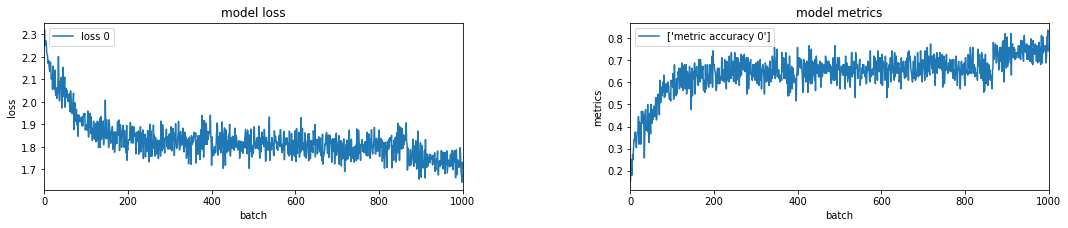

最低 loss 1.6435e+00  最佳 metrics 83.5938%  最後10次 metrics 76.0938%
正常樣本 accuracy 73.3359%  DIFF: -2.7578% 
噪聲樣本 accuracy 62.6094%  DIFF: -13.4844% 
梯度為零比例 : 40.957%


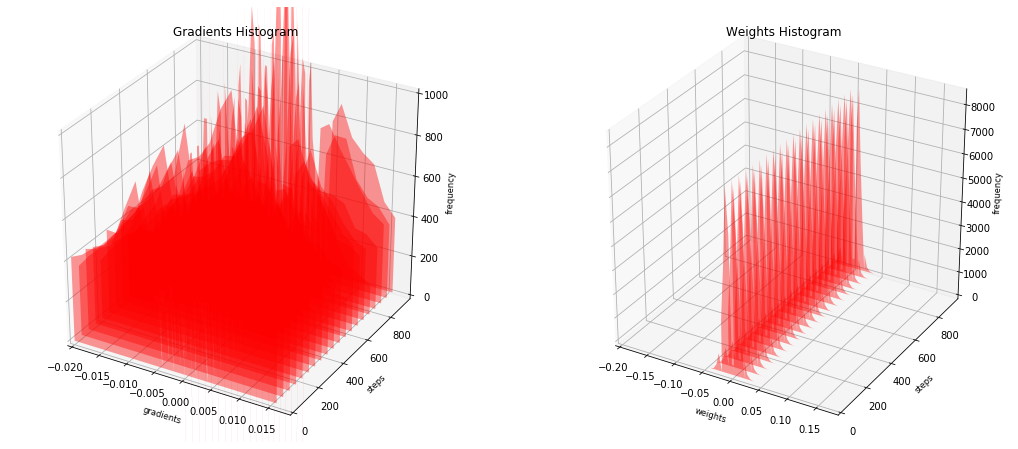

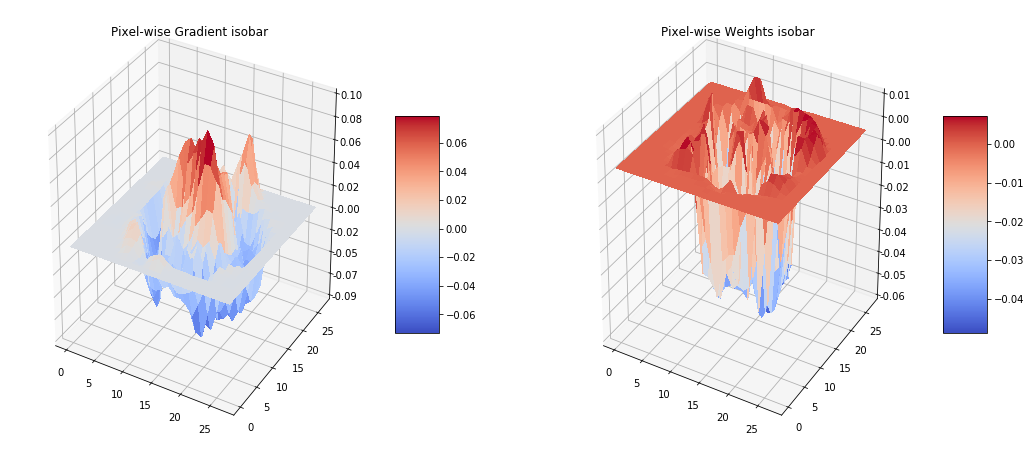

In [7]:
test_activity_function('relu')

leaky_relu
6.034279 sec
  Step: 11s356ms | Tot: 0ms      | Loss: 2.367   | Accuracy: 11.719%  | learning rate: 0.0010    | epoch: 0 ( 0/1000 )
  Step: 649ms    | Tot: 649ms    | Loss: 2.085   | Accuracy: 39.609%  | learning rate: 0.0010    | epoch: 0 ( 100/1000 )
  Step: 622ms    | Tot: 1s271ms  | Loss: 1.810   | Accuracy: 68.141%  | learning rate: 0.0010    | epoch: 0 ( 200/1000 )
  Step: 698ms    | Tot: 1s969ms  | Loss: 1.762   | Accuracy: 72.000%  | learning rate: 0.0010    | epoch: 0 ( 300/1000 )
  Step: 576ms    | Tot: 2s546ms  | Loss: 1.717   | Accuracy: 76.609%  | learning rate: 0.0010    | epoch: 0 ( 400/1000 )
  Step: 660ms    | Tot: 3s206ms  | Loss: 1.664   | Accuracy: 81.922%  | learning rate: 0.0010    | epoch: 0 ( 500/1000 )
  Step: 648ms    | Tot: 3s854ms  | Loss: 1.652   | Accuracy: 82.727%  | learning rate: 0.0010    | epoch: 0 ( 600/1000 )
  Step: 671ms    | Tot: 4s525ms  | Loss: 1.644   | Accuracy: 83.477%  | learning rate: 0.0010    | epoch: 0 ( 700/1000 )
  Step: 62

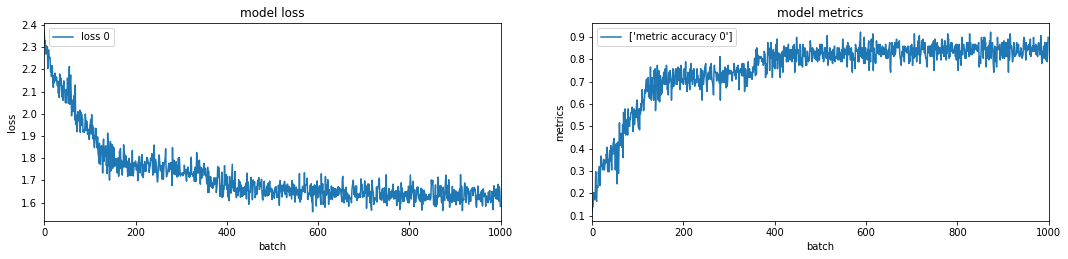

最低 loss 1.5587e+00  最佳 metrics 92.1875%  最後10次 metrics 83.4375%
正常樣本 accuracy 83.4453%  DIFF: 0.0078% 
噪聲樣本 accuracy 72.3281%  DIFF: -11.1094% 
梯度為零比例 : 32.718%


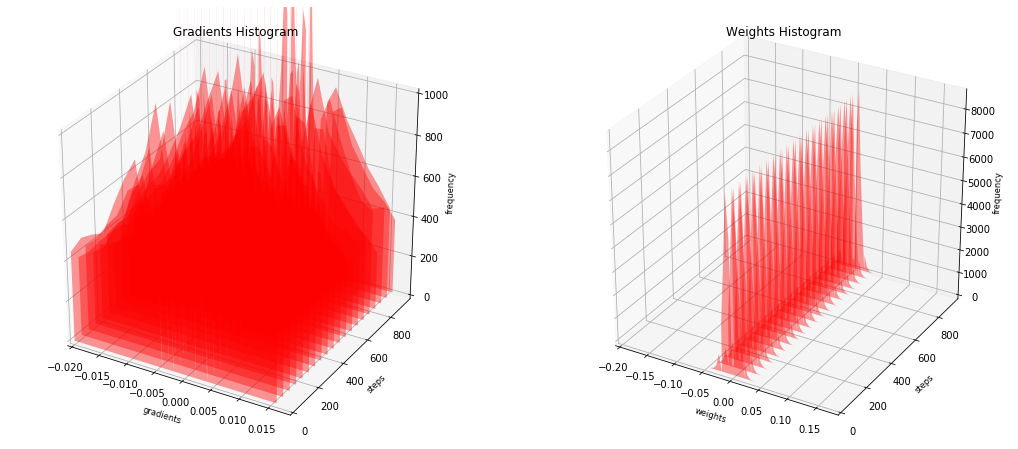

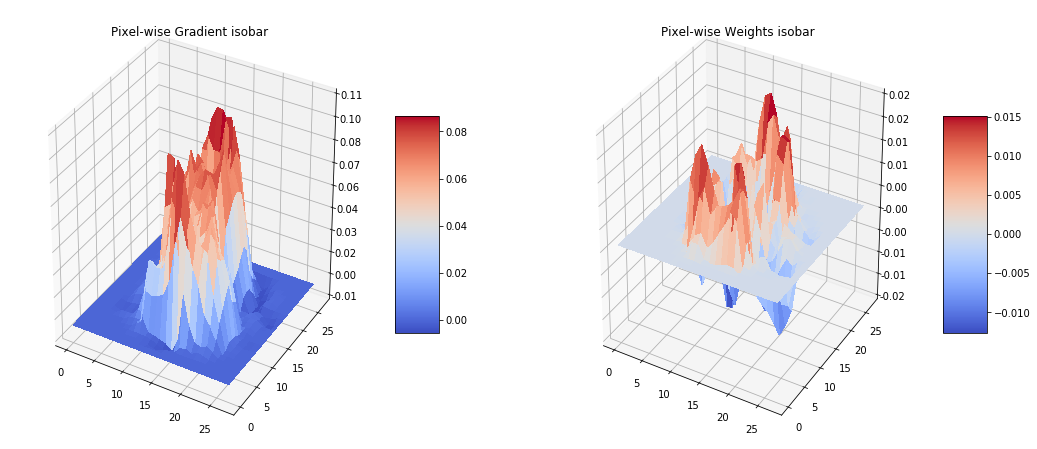

In [8]:
test_activity_function('leaky_relu')

sigmoid
6.416879 sec
  Step: 10s870ms | Tot: 0ms      | Loss: 2.300   | Accuracy: 13.281%  | learning rate: 0.0010    | epoch: 0 ( 0/1000 )
  Step: 642ms    | Tot: 642ms    | Loss: 2.299   | Accuracy: 14.469%  | learning rate: 0.0010    | epoch: 0 ( 100/1000 )
  Step: 611ms    | Tot: 1s253ms  | Loss: 2.296   | Accuracy: 20.219%  | learning rate: 0.0010    | epoch: 0 ( 200/1000 )
  Step: 620ms    | Tot: 1s873ms  | Loss: 2.293   | Accuracy: 22.484%  | learning rate: 0.0010    | epoch: 0 ( 300/1000 )
  Step: 664ms    | Tot: 2s538ms  | Loss: 2.289   | Accuracy: 26.508%  | learning rate: 0.0010    | epoch: 0 ( 400/1000 )
  Step: 603ms    | Tot: 3s141ms  | Loss: 2.286   | Accuracy: 29.563%  | learning rate: 0.0010    | epoch: 0 ( 500/1000 )
  Step: 625ms    | Tot: 3s766ms  | Loss: 2.282   | Accuracy: 33.109%  | learning rate: 0.0010    | epoch: 0 ( 600/1000 )
  Step: 623ms    | Tot: 4s390ms  | Loss: 2.280   | Accuracy: 34.547%  | learning rate: 0.0010    | epoch: 0 ( 700/1000 )
  Step: 635ms

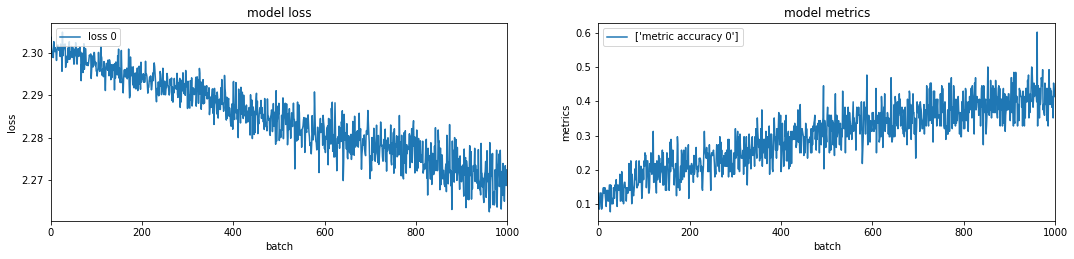

最低 loss 2.2624e+00  最佳 metrics 60.1562%  最後10次 metrics 41.2500%
正常樣本 accuracy 42.1797%  DIFF: 0.9297% 
噪聲樣本 accuracy 35.5156%  DIFF: -5.7344% 
梯度為零比例 : 34.340%


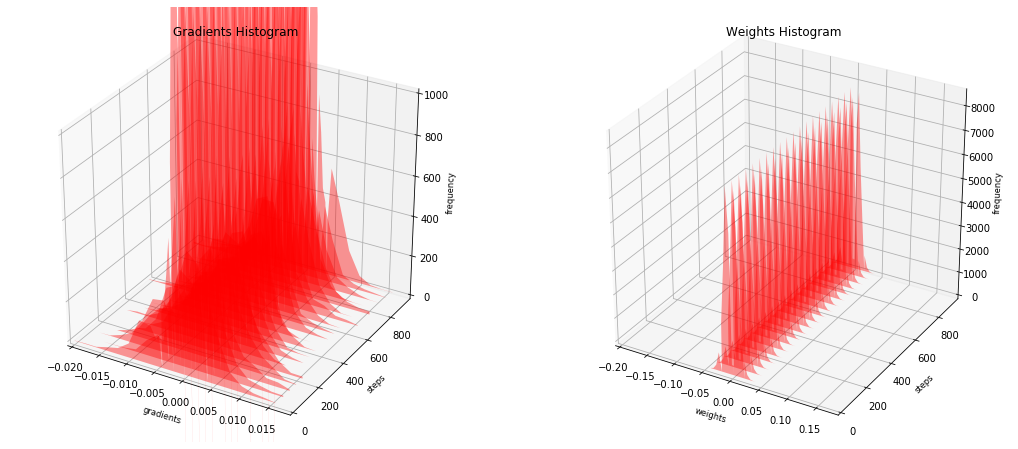

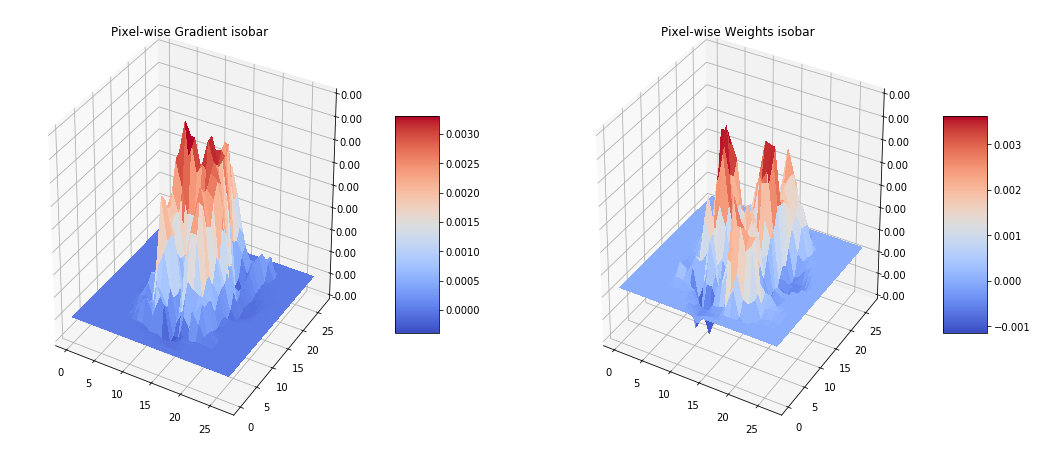

In [9]:
test_activity_function('sigmoid')

tanh
6.790383 sec
  Step: 11s336ms | Tot: 0ms      | Loss: 2.306   | Accuracy: 9.375%   | learning rate: 0.0010    | epoch: 0 ( 0/1000 )
  Step: 628ms    | Tot: 628ms    | Loss: 2.298   | Accuracy: 14.641%  | learning rate: 0.0010    | epoch: 0 ( 100/1000 )
  Step: 692ms    | Tot: 1s320ms  | Loss: 2.286   | Accuracy: 26.844%  | learning rate: 0.0010    | epoch: 0 ( 200/1000 )
  Step: 677ms    | Tot: 1s997ms  | Loss: 2.272   | Accuracy: 37.422%  | learning rate: 0.0010    | epoch: 0 ( 300/1000 )
  Step: 615ms    | Tot: 2s613ms  | Loss: 2.258   | Accuracy: 46.836%  | learning rate: 0.0010    | epoch: 0 ( 400/1000 )
  Step: 659ms    | Tot: 3s272ms  | Loss: 2.242   | Accuracy: 54.937%  | learning rate: 0.0010    | epoch: 0 ( 500/1000 )
  Step: 618ms    | Tot: 3s890ms  | Loss: 2.227   | Accuracy: 59.328%  | learning rate: 0.0010    | epoch: 0 ( 600/1000 )
  Step: 586ms    | Tot: 4s477ms  | Loss: 2.214   | Accuracy: 61.711%  | learning rate: 0.0010    | epoch: 0 ( 700/1000 )
  Step: 612ms   

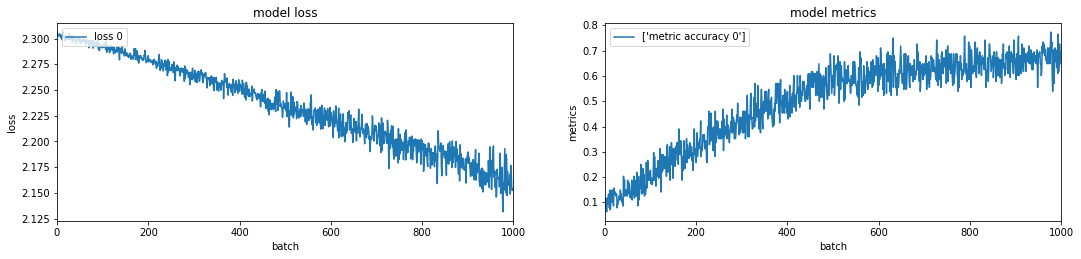

最低 loss 2.1316e+00  最佳 metrics 77.3438%  最後10次 metrics 67.3438%
正常樣本 accuracy 65.5781%  DIFF: -1.7656% 
噪聲樣本 accuracy 61.4375%  DIFF: -5.9063% 
梯度為零比例 : 41.676%


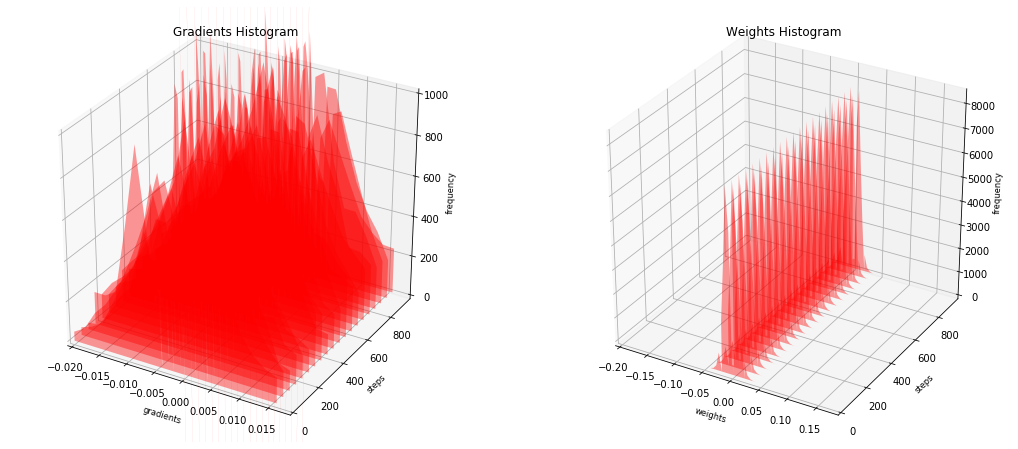

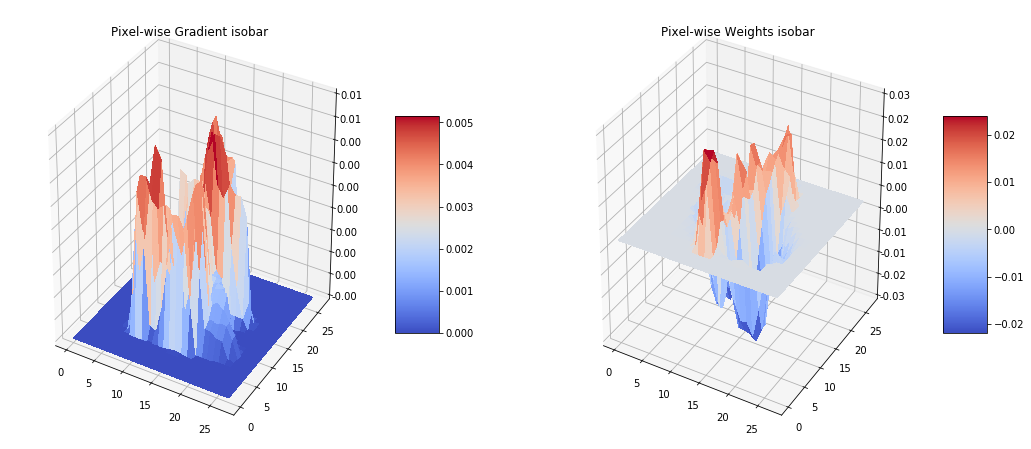

In [10]:
test_activity_function('tanh')

selu
6.875649 sec
  Step: 12s81ms  | Tot: 0ms      | Loss: 2.324   | Accuracy: 16.406%  | learning rate: 0.0010    | epoch: 0 ( 0/1000 )
  Step: 803ms    | Tot: 803ms    | Loss: 1.977   | Accuracy: 52.000%  | learning rate: 0.0010    | epoch: 0 ( 100/1000 )
  Step: 863ms    | Tot: 1s667ms  | Loss: 1.711   | Accuracy: 79.102%  | learning rate: 0.0010    | epoch: 0 ( 200/1000 )
  Step: 865ms    | Tot: 2s533ms  | Loss: 1.623   | Accuracy: 87.562%  | learning rate: 0.0010    | epoch: 0 ( 300/1000 )
  Step: 847ms    | Tot: 3s380ms  | Loss: 1.592   | Accuracy: 89.992%  | learning rate: 0.0010    | epoch: 0 ( 400/1000 )
  Step: 870ms    | Tot: 4s251ms  | Loss: 1.583   | Accuracy: 90.555%  | learning rate: 0.0010    | epoch: 0 ( 500/1000 )
  Step: 830ms    | Tot: 5s82ms   | Loss: 1.568   | Accuracy: 91.859%  | learning rate: 0.0010    | epoch: 0 ( 600/1000 )
  Step: 955ms    | Tot: 6s37ms   | Loss: 1.563   | Accuracy: 92.195%  | learning rate: 0.0010    | epoch: 0 ( 700/1000 )
  Step: 879ms   

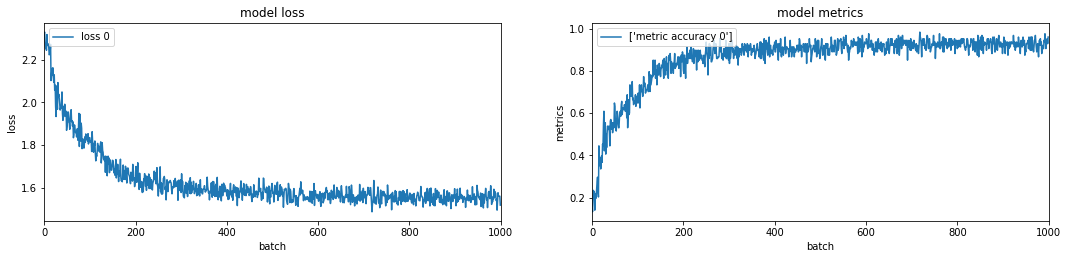

最低 loss 1.4889e+00  最佳 metrics 98.4375%  最後10次 metrics 94.1406%
正常樣本 accuracy 92.4766%  DIFF: -1.6641% 
噪聲樣本 accuracy 79.9844%  DIFF: -14.1563% 
梯度為零比例 : 35.685%


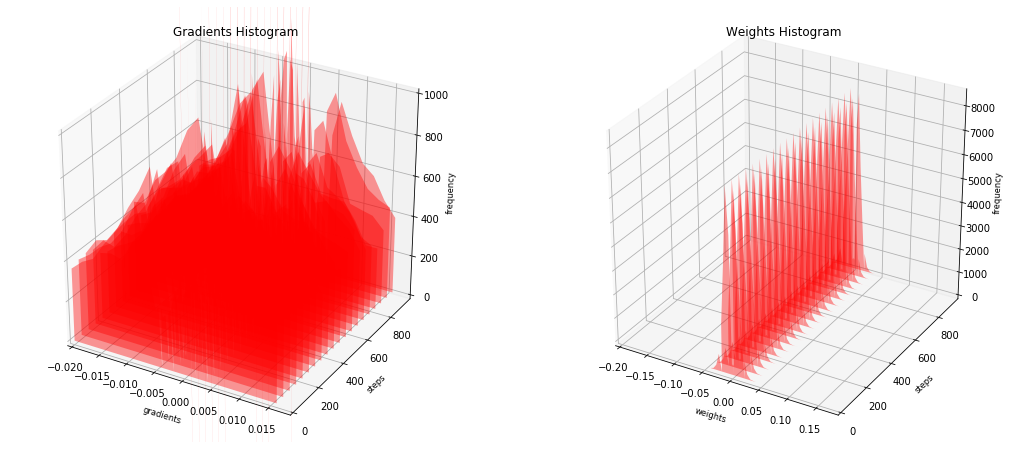

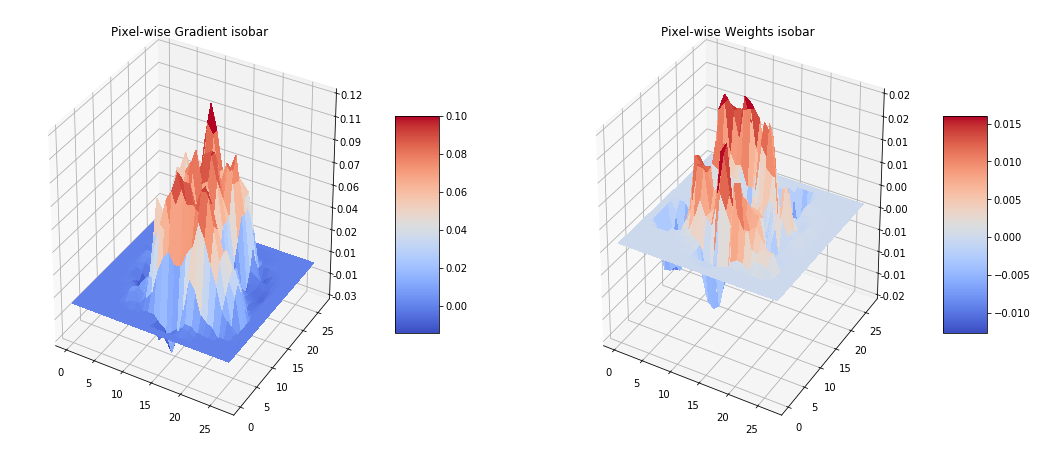

In [11]:
test_activity_function('selu')

swish
13.062081 sec
  Step: 18s654ms | Tot: 0ms      | Loss: 2.371   | Accuracy: 9.375%   | learning rate: 0.0010    | epoch: 0 ( 0/1000 )
  Step: 729ms    | Tot: 729ms    | Loss: 1.949   | Accuracy: 56.055%  | learning rate: 0.0010    | epoch: 0 ( 100/1000 )
  Step: 794ms    | Tot: 1s524ms  | Loss: 1.717   | Accuracy: 77.977%  | learning rate: 0.0010    | epoch: 0 ( 200/1000 )
  Step: 833ms    | Tot: 2s358ms  | Loss: 1.675   | Accuracy: 81.266%  | learning rate: 0.0010    | epoch: 0 ( 300/1000 )
  Step: 777ms    | Tot: 3s136ms  | Loss: 1.659   | Accuracy: 82.492%  | learning rate: 0.0010    | epoch: 0 ( 400/1000 )
  Step: 833ms    | Tot: 3s969ms  | Loss: 1.649   | Accuracy: 83.141%  | learning rate: 0.0010    | epoch: 0 ( 500/1000 )
  Step: 745ms    | Tot: 4s714ms  | Loss: 1.648   | Accuracy: 83.227%  | learning rate: 0.0010    | epoch: 0 ( 600/1000 )
  Step: 810ms    | Tot: 5s525ms  | Loss: 1.644   | Accuracy: 83.508%  | learning rate: 0.0010    | epoch: 0 ( 700/1000 )
  Step: 774ms 

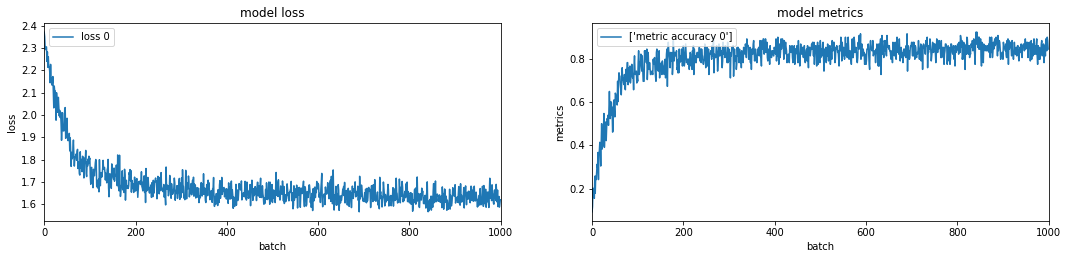

最低 loss 1.5656e+00  最佳 metrics 92.1875%  最後10次 metrics 84.8438%
正常樣本 accuracy 83.3047%  DIFF: -1.5391% 
噪聲樣本 accuracy 70.8281%  DIFF: -14.0156% 
梯度為零比例 : 32.745%


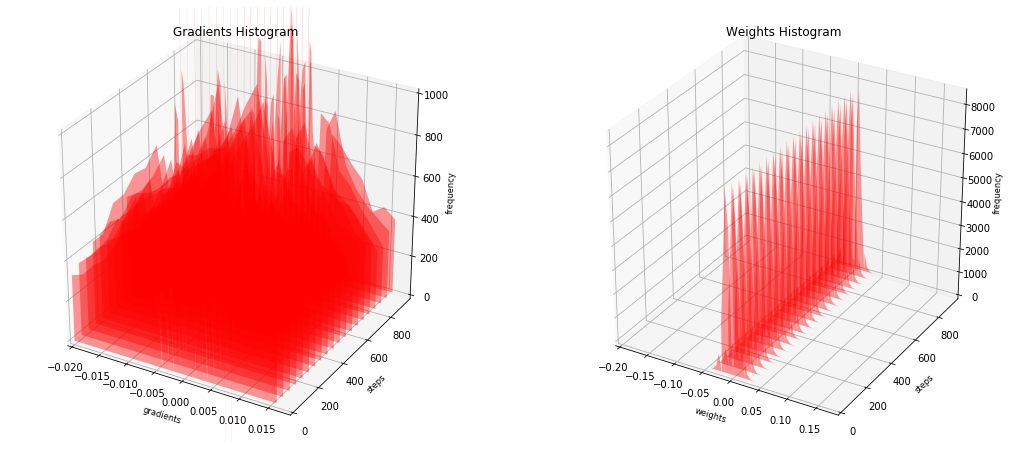

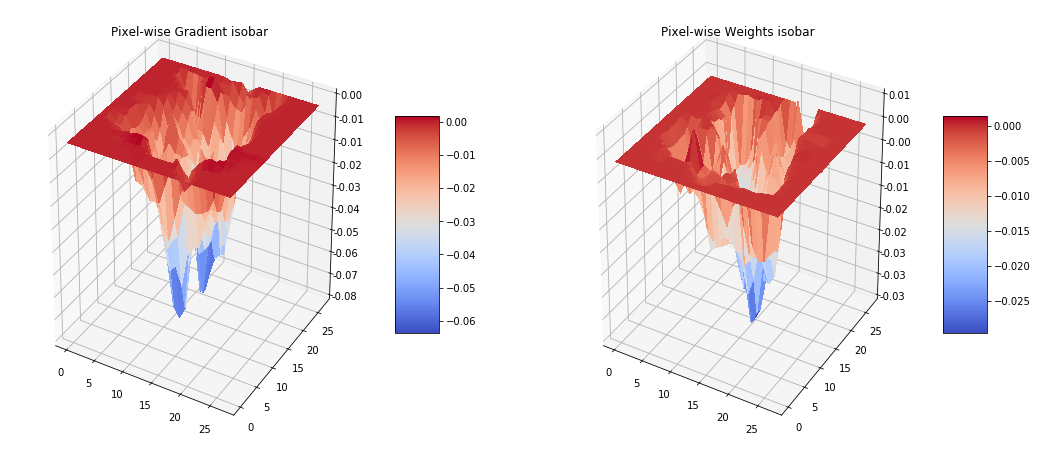

In [12]:
test_activity_function('swish')

mish
18.023515 sec
  Step: 23s38ms  | Tot: 0ms      | Loss: 2.320   | Accuracy: 14.062%  | learning rate: 0.0010    | epoch: 0 ( 0/1000 )
  Step: 782ms    | Tot: 782ms    | Loss: 2.075   | Accuracy: 40.594%  | learning rate: 0.0010    | epoch: 0 ( 100/1000 )
  Step: 831ms    | Tot: 1s614ms  | Loss: 1.887   | Accuracy: 59.766%  | learning rate: 0.0010    | epoch: 0 ( 200/1000 )
  Step: 854ms    | Tot: 2s469ms  | Loss: 1.842   | Accuracy: 63.688%  | learning rate: 0.0010    | epoch: 0 ( 300/1000 )
  Step: 840ms    | Tot: 3s310ms  | Loss: 1.827   | Accuracy: 64.602%  | learning rate: 0.0010    | epoch: 0 ( 400/1000 )
  Step: 799ms    | Tot: 4s110ms  | Loss: 1.816   | Accuracy: 65.742%  | learning rate: 0.0010    | epoch: 0 ( 500/1000 )
  Step: 793ms    | Tot: 4s903ms  | Loss: 1.765   | Accuracy: 71.781%  | learning rate: 0.0010    | epoch: 0 ( 600/1000 )
  Step: 825ms    | Tot: 5s729ms  | Loss: 1.746   | Accuracy: 73.445%  | learning rate: 0.0010    | epoch: 0 ( 700/1000 )
  Step: 841ms  

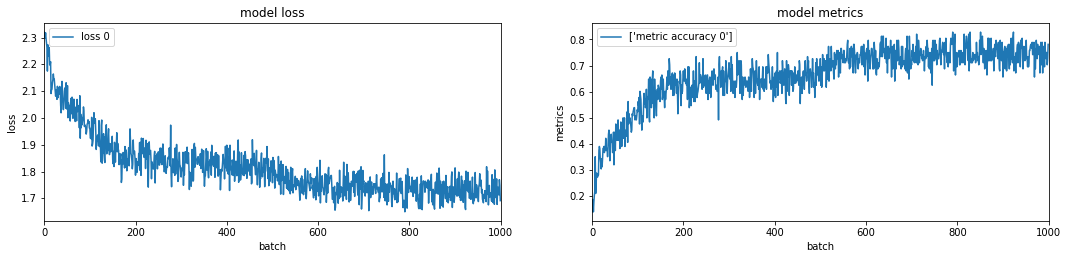

最低 loss 1.6500e+00  最佳 metrics 82.8125%  最後10次 metrics 74.4531%
正常樣本 accuracy 73.6875%  DIFF: -0.7656% 
噪聲樣本 accuracy 60.2813%  DIFF: -14.1719% 
梯度為零比例 : 32.748%


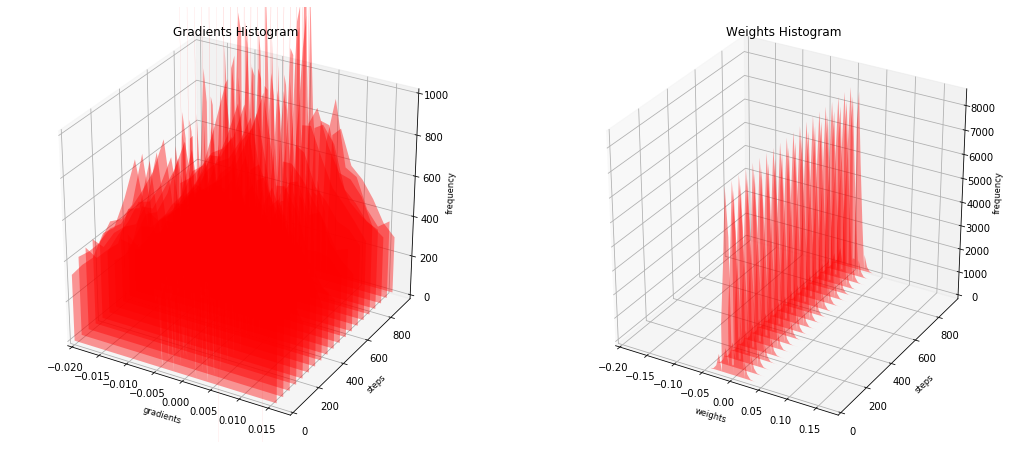

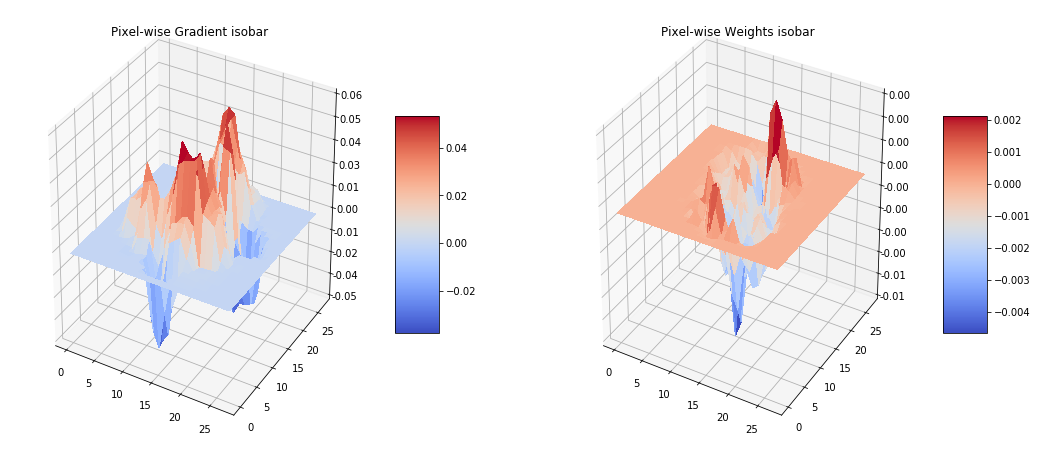

In [13]:
test_activity_function('mish')

In [14]:
import pandas
pd=pandas.DataFrame.from_dict(performance_dict)
pd

,relu,leaky_relu,sigmoid,tanh,selu,swish,mish
噪聲樣本 accuracy DIFF,-0.134844,-0.111094,-0.057344,-0.059063,-0.141563,-0.140156,-0.141719
最佳 metrics,0.835938,0.921875,0.601562,0.773438,0.984375,0.921875,0.828125
最後10次 metrics,0.760938,0.834375,0.412500,0.673438,0.941406,0.848437,0.744531
梯度為零比例,0.409575,0.327182,0.343400,0.416761,0.356845,0.327454,0.327480
正常樣本 accuracy DIFF,-0.027578,0.000078,0.009297,-0.017656,-0.016641,-0.015391,-0.007656
負梯度比例,0.295035,0.337886,0.329178,0.287672,0.322912,0.342202,0.337729
跑 10 萬次的總時間,8.023595,6.034279,6.416879,6.790383,6.875649,13.062081,18.023515
